In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, roc_auc_score, f1_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from sklearn.svm import SVR

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.*')

In [19]:
data = pd.read_csv('dataset.csv', header = 0)

In [20]:
# select top 10 most frequent genre
top_10_genres = data['track_genre'].value_counts().head(10).index
filtered_df = data[data['track_genre'].isin(top_10_genres)]
filtered_df = pd.get_dummies(filtered_df , columns=['track_genre'])
data = filtered_df

In [21]:
# drop irrelevant columns
data = data.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'], axis = 1)
data.shape

(10000, 25)

In [23]:
# create labels
data['isPopular'] = np.where(data['popularity'] > 1 , 1, 0)

In [24]:
# get X and Y
y = data['isPopular']
X = data.drop(['popularity','isPopular'], axis = 1)

In [25]:
# stratified train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [26]:
# user Min-Max scaler 
scaler = MinMaxScaler()
cols = ['duration_ms', 'loudness', 'key']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

In [27]:
X_train.head()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,track_genre_acoustic,track_genre_opera,track_genre_pagode,track_genre_party,track_genre_piano,track_genre_pop,track_genre_pop-film,track_genre_power-pop,track_genre_progressive-house,track_genre_punk-rock
161,0.135773,False,0.505,0.2100,1.000000,0.731745,1,0.0295,0.907,0.00000,...,True,False,False,False,False,False,False,False,False,False
76083,0.200171,False,0.271,0.0140,0.727273,0.437974,1,0.0676,0.994,0.00012,...,False,True,False,False,False,False,False,False,False,False
2,0.167871,False,0.438,0.3590,0.000000,0.767986,1,0.0557,0.210,0.00000,...,True,False,False,False,False,False,False,False,False,False
76101,0.145547,False,0.344,0.4040,0.000000,0.818612,1,0.0358,0.829,0.00000,...,False,True,False,False,False,False,False,False,False,False
79348,0.187889,False,0.601,0.0847,0.818182,0.595822,1,0.0327,0.991,0.89800,...,False,False,False,False,True,False,False,False,False,False


### Exploratory Data Analysis

In [28]:
data['popularity'].describe()

count    10000.000000
mean        39.626500
std         21.707545
min          0.000000
25%         24.000000
50%         42.000000
75%         57.000000
max        100.000000
Name: popularity, dtype: float64

In [29]:
percentile = percentileofscore(data['popularity'], 65, kind='rank')
percentile

88.58

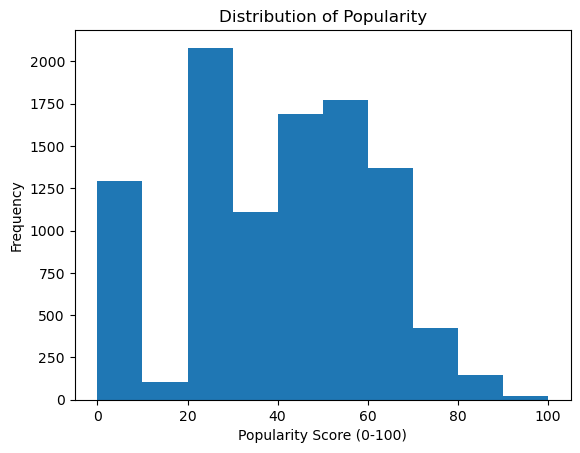

In [30]:
bin_edges = [0,10,20,30,40,50,60,70,80,90,100]
plt.hist(data['popularity'], bins=bin_edges)  # Adjust the number of bins as necessary
plt.title('Distribution of Popularity')
plt.xlabel('Popularity Score (0-100)')
plt.ylabel('Frequency')
plt.show()

In [31]:
data['loudness'].describe()

count    10000.000000
mean        -8.455762
std          5.772221
min        -43.957000
25%         -9.717500
50%         -6.829000
75%         -4.935000
max          0.605000
Name: loudness, dtype: float64

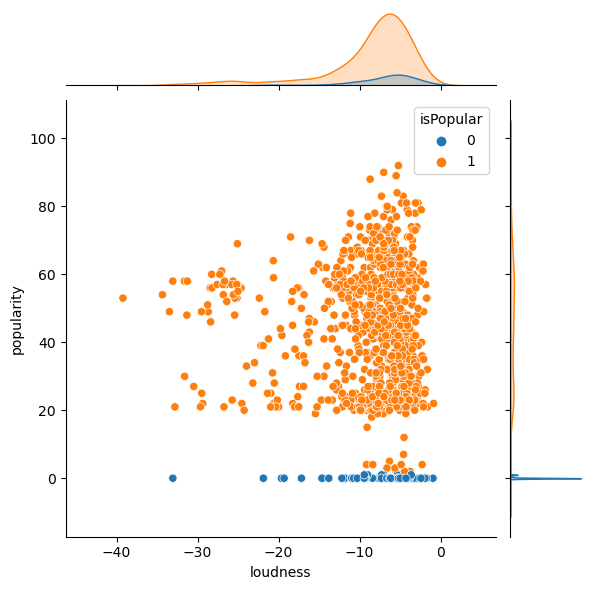

In [32]:
sample = data.sample(n=1000, random_state=42)
sns.jointplot(x='loudness', y='popularity',hue= 'isPopular', data=sample, kind='scatter')
plt.show()

In [33]:
hue= 'isPopular'

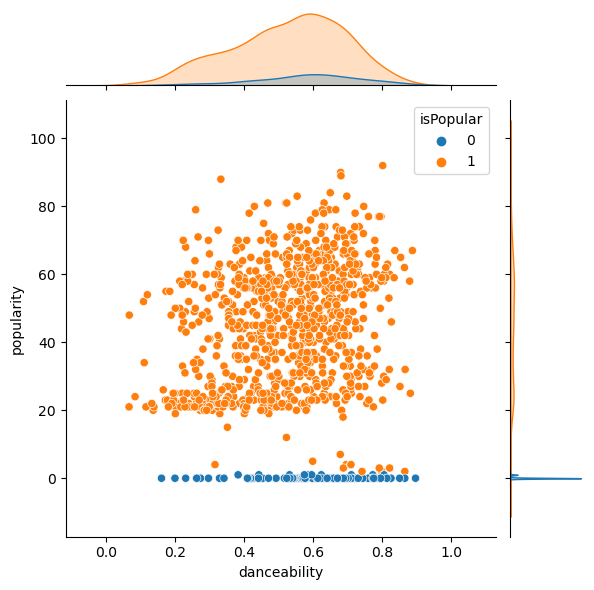

In [34]:
sample = data.sample(n=1000, random_state=42)
sns.jointplot(x='danceability', y='popularity', hue= 'isPopular', data=sample, kind='scatter')
plt.show()

### Binary Classification 

10th percentile threshold are using as an example, results for 50th and 90th percentile are genrated with same code but different threhold

#### Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver='saga')

param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': np.linspace(0, 1, 10)
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

predictions_proba = best_model.predict_proba(X_test)[:, 1]

In [48]:
# Calculate Evaluation Metrics
auc = roc_auc_score(y_test, predictions_proba)
print("AUC-ROC:", auc)
predictions = best_model.predict(X_test)
f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)

# Print Cofficients
features = X.columns
coefficients = best_model.coef_[0]
feature_coefficients = dict(zip(features, coefficients))

print("Feature Coefficients:")
for feature, coeff in feature_coefficients.items():
    print(f"{feature}: {coeff}")

AUC-ROC: 0.7290009253810459
F1 Score: 0.9408649602824359
Feature Coefficients:
duration_ms: 0.06268806818072542
explicit: 0.2669011004178465
danceability: -0.10488920573324301
energy: -0.08107902707129735
key: 0.1027347411012418
loudness: -0.10590548665203788
mode: -0.11920842746903426
speechiness: 0.022376917762897023
acousticness: 0.5741233176614775
instrumentalness: -0.0027428594938677187
liveness: 0.42841574769498825
valence: -0.010238526615919202
tempo: -0.0016236742563484096
time_signature: 0.5131931871005424
track_genre_acoustic: 0.4628501722429148
track_genre_opera: -0.3785387385013866
track_genre_pagode: 0.6927974227983762
track_genre_party: -1.1013301593753935
track_genre_piano: -0.26832299704670115
track_genre_pop: -0.8999263467573064
track_genre_pop-film: 1.3990180261239484
track_genre_power-pop: 0.6453553540082552
track_genre_progressive-house: -0.12898409737579006
track_genre_punk-rock: -0.04609570478788011


#### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svm = SVC(max_iter=1000, probability=True)

param_grid = {
    'C': np.logspace(-4, 4, 10),
    'kernel': ['poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [50]:
predictions_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, predictions_proba)
print("AUC-ROC:", auc)
predictions = best_model.predict(X_test)
f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)

AUC-ROC: 0.6405843601618968
F1 Score: 0.9410518884574656


#### Random Forest

In [51]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [52]:
# Predict probabilities for AUC computation
predictions_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
auc = roc_auc_score(y_test, predictions_proba)
print("AUC-ROC:", auc)

# Calculate and print F1 score
predictions = best_model.predict(X_test)
f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)

AUC-ROC: 0.863139063208916
F1 Score: 0.9498291674159324


In [53]:
# get feature importance for interpretation
features = X.columns
importances = best_model.feature_importances_
feature_importances = dict(zip(features, importances))

print("Feature Importances:")
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

Feature Importances:
duration_ms: 0.08417639939230591
explicit: 0.0016745105893616696
danceability: 0.09065684829995367
energy: 0.08723600090045273
key: 0.04292775195360564
loudness: 0.08741467172056673
mode: 0.009534371897977815
speechiness: 0.07902507642534856
acousticness: 0.09522527697515856
instrumentalness: 0.057527035778685134
liveness: 0.07853268805971698
valence: 0.07865376911170151
tempo: 0.09361755397774807
time_signature: 0.010471192376469287
track_genre_acoustic: 0.003684006524868978
track_genre_opera: 0.004544825754048105
track_genre_pagode: 0.01134918189580836
track_genre_party: 0.029170991672383774
track_genre_piano: 0.00517946982045208
track_genre_pop: 0.022568324067194664
track_genre_pop-film: 0.01314758225908806
track_genre_power-pop: 0.004527121163097681
track_genre_progressive-house: 0.00427987523154415
track_genre_punk-rock: 0.004875474152461864


#### LightGBM

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [56]:
predictions_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, predictions_proba)
print("AUC-ROC:", auc)
predictions = best_model.predict(X_test)
f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC-ROC: 0.8590248235711623
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
F1 Score: 0.9517091698317959


#### MLP

In [58]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(random_state=42)


grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

/Users/louislu/opt/anaconda3/envs/cs534/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louislu/opt/anaconda3/envs/cs534/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louislu/opt/anaconda3/envs/cs534/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'sgd']},
             scoring='roc_auc')

In [59]:
best_model = grid_search.best_estimator_
predictions_proba = best_model.predict_proba(X_test)[:, 1]
predictions = best_model.predict(X_test)

auc = roc_auc_score(y_test, predictions_proba)
f1 = f1_score(y_test, predictions)
print("AUC-ROC:", auc)
print("F1 Score:", f1)

AUC-ROC: 0.7307247844895355
F1 Score: 0.9410518884574656
